### Import

In [1]:
from predict_ensemble_and_evaluate import predict_ensemble_and_evaluate
from predict_ensemble_and_evaluate import plot_roc_comparison

## Display function

In [2]:
#function for displaying ROC curves of multiple classifiers

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc

def plot_roc_connected_points(results_list, results_original_roc, name="All Classifiers"):
    """
    Creates a plot showing the performance of all classifiers as points,
    and connects them with a line, sorted by FPR.

    Args:
        results_list: A list of dictionaries, where each dict contains 'fpr', 'tpr'.
    """
    if not results_list:
        print("No results to plot.")
        return

    # Convert results to a pandas DataFrame for easy sorting
    df = pd.DataFrame(results_list)
    
    # Sort the models by their False Positive Rate to create a left-to-right line
    df_sorted = df.sort_values(by='fpr').reset_index(drop=True)
    
    # --- Plotting ---
    plt.figure(figsize=(10, 10))
    
    # Plot all the individual model points as a scatter plot
    # This helps see the actual performance of each model
    plt.scatter(df_sorted['fpr'], df_sorted['tpr'], c='black', marker='o', 
                alpha=0.6, s=100, zorder=3) # zorder=3 puts dots on top

    # Plot the line connecting the points
    plt.plot(df_sorted['fpr'], df_sorted['tpr'], color='red', lw=1.5,
             alpha=0.8, label=f'{name} (AUC = {auc(df_sorted["fpr"], df_sorted["tpr"]):.2f})')
    
    #plot the original ROC curve
    plt.plot(results_original_roc["fpr"], results_original_roc["tpr"], color='blue', 
             label=f'{results_original_roc["name"]} (AUC = {results_original_roc["auc"]:.2f})')

    # Plot the "no-skill" line for reference
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Performance Path of All Trained Classifiers')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

## Best ROC envelope

In [3]:
import numpy as np
from sklearn.metrics import roc_curve

def get_best_roc_envelope(results_list, results_original_roc=None):
    """
    Constructs the upper envelope of multiple ROC curves to find the best
    possible operating points from a collection of classifiers.

    This function is guaranteed to produce a list of points that starts at
    (FPR=0, TPR=0) and ends at (FPR=1, TPR=1), making it suitable for direct
    plotting and AUC calculation.

    Args:
        results_list (list): A list of dictionaries. Each dictionary must
                             contain a 'model' name and the full ROC results
                             under the 'full_roc' key.
        results_original_roc (dict, optional): A dictionary containing the
                                               ROC results of a baseline model,
                                               which will also be included in
                                               the comparison. Defaults to None.

    Returns:
        list: A sorted list of dictionaries representing the optimal ROC
              envelope. Each dictionary includes 'model', 'fpr', 'tpr',
              and 'threshold'.
    """
    all_points = []

    # Step 1: Gather all ROC points from all provided models
    all_results = results_list[:]
    if results_original_roc:
        all_results.append({
            'model': 'original_baseline',
            'full_roc': results_original_roc
        })

    for result in all_results:
        model_name = result.get('model', 'Unknown Model')
        roc = result.get('full_roc')
        if not roc: continue

        fprs = roc.get('fpr', [])
        tprs = roc.get('tpr', [])
        thresholds = roc.get('thresholds', [])

        for i in range(len(fprs)):
            threshold = thresholds[i] if i < len(thresholds) else thresholds[-1]
            all_points.append({
                'model': model_name, 'fpr': fprs[i],
                'tpr': tprs[i], 'threshold': threshold
            })

    # Handle case with no data by returning a default diagonal line
    if not all_points:
        return [
            {'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf},
            {'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0}
        ]

    # Step 2: Sort all points by FPR (asc), then by TPR (desc)
    all_points.sort(key=lambda p: (p['fpr'], -p['tpr']))

    # Step 3: Build the core ROC envelope
    best_roc_envelope = []
    max_tpr_so_far = -1.0
    for point in all_points:
        # Add a point only if it has a strictly higher TPR
        if point['tpr'] > max_tpr_so_far:
            # To prevent adding multiple points at the same FPR, check if the last point
            # has the same FPR and replace it if so (since this one has a higher TPR)
            if best_roc_envelope and best_roc_envelope[-1]['fpr'] == point['fpr']:
                best_roc_envelope[-1] = point
            else:
                best_roc_envelope.append(point)
            max_tpr_so_far = point['tpr']
    
    # Step 4: Manually add extremities if they are missing
    
    # Ensure the curve starts at (0, 0)
    if not best_roc_envelope or best_roc_envelope[0]['fpr'] > 0.0:
        best_roc_envelope.insert(0, {
            'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf
        })

    # Ensure the curve ends at (1, 1)
    if best_roc_envelope[-1]['fpr'] < 1.0 or best_roc_envelope[-1]['tpr'] < 1.0:
        best_roc_envelope.append({
            'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0
        })

    return best_roc_envelope

## Data generation

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def generate_data(dataset):
    if dataset == "data1":
        no_predictors = 2
        no_samples = 1600
        no_classes = 2
        #kerneltype = 'linear'  #comment out for polynomial kernel
        #kerneltype = 'poly'  #comment out for linear kernel



        n_samples_per_cluster = 400
        n_clusters = 4

        # Create the clusters deterministically
        np.random.seed(0) # for reproducibility

        X = np.zeros((n_samples_per_cluster * n_clusters, 2))
        y = np.zeros(n_samples_per_cluster * n_clusters)

        # Cluster centers in corners of a square
        centers = [[0, 0], [2, 0], [0, 2], [2, 2]]

        # Assign points to clusters deterministically
        for i in range(n_clusters):
            cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
            X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
            if i == 0 or i == 3:
                y[cluster_indices] = 0
            else:
                y[cluster_indices] = 1



        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('Four Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        #add intercept to X
        #X = np.hstack((np.ones((X.shape[0], 1)), X))

        # # shuffle data
        # permutation = np.random.permutation(no_samples)
        # X = X[permutation]
        # y = y[permutation]


        #Split data into training and testing sets
        # Step 1: Split off the 1000 training samples. The rest (600) go into a temporary pool.
        # We can use absolute numbers for the size.
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            train_size=1000,  # Specify exactly 1000 samples for training
            random_state=42,
            stratify=y        # Crucial for classification: keeps class proportions the same
        )

        

        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)

        val_data = test_data

        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")
    elif dataset == "data2":
        no_predictors = 2
        no_samples = 1600
        no_classes = 2
        #kerneltype = 'linear'  #comment out for polynomial kernel
        #kerneltype = 'poly'  #comment out for linear kernel



        n_samples_per_cluster = 400
        n_clusters = 4

        # Create the clusters deterministically
        np.random.seed(0) # for reproducibility

        X = np.zeros((n_samples_per_cluster * n_clusters, 2))
        y = np.zeros(n_samples_per_cluster * n_clusters)

        # Cluster centers in corners of a square
        centers = [[0, 0], [2, 0], [1, 2], [1, 2]]

        # Assign points to clusters deterministically
        for i in range(n_clusters):
            cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
            X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
            if i == 0 or i == 3:
                y[cluster_indices] = 0
            else:
                y[cluster_indices] = 1



        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('Four Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        #add intercept to X
        #X = np.hstack((np.ones((X.shape[0], 1)), X))

        # # shuffle data
        # permutation = np.random.permutation(no_samples)
        # X = X[permutation]
        # y = y[permutation]


        #Split data into training and testing sets
        # Step 1: Split off the 1000 training samples. The rest (600) go into a temporary pool.
        # We can use absolute numbers for the size.
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            train_size=1000,  # Specify exactly 1000 samples for training
            random_state=42,
            stratify=y        # Crucial for classification: keeps class proportions the same
        )


        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)

        val_data = test_data

        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")

    elif dataset == "pneumoniaMNIST":
        import medmnist
        print(medmnist.__version__)
        # read in the PneumoniaMNIST dataset
        from medmnist import PneumoniaMNIST
        train_data = PneumoniaMNIST(split='train', download=True, size=224)
        test_data = PneumoniaMNIST(split='test', download=True, size=224)
        val_data = PneumoniaMNIST(split='val', download=True, size=224)
        # print the dataset info
        print(f"Number of training samples: {len(train_data)}")
        print(f"Number of test samples: {len(test_data)}")
        print(f"Number of validation samples: {len(val_data)}")

    return train_data, test_data, val_data


## Data1: NN

In [5]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

In [6]:
# Define constants
BATCH_SIZE = 64
LEARNING_RATE = 0.001
IMAGE_SIZE = 224
NUM_CLASSES = 1
NUM_CHANNELS = 1
NUM_EPOCHS = 1
NUM_WORKERS = 4
K_FOLDS = 4

### Lightning module

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
import torchmetrics
import numpy as np

# A simple classifier head
class SimpleClassifier(nn.Module):
    def __init__(self, input_features=2, hidden_units=32, num_classes=1):
        """
        Args:
            input_features (int): Number of input features (2 for your data)
            hidden_units (int): Number of neurons in the hidden layer
            num_classes (int): Number of output classes (1 for binary)
        """
        super().__init__()
        self.layer_stack = nn.Sequential(
            # --- Hidden Layer 1 ---
            # Takes 2 features in, outputs a hidden representation of size 32
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),  # <-- The crucial non-linear activation function

            # --- Output Layer ---
            # Takes the 16-unit hidden representation, outputs 1 logit
            nn.Linear(in_features=hidden_units, out_features=num_classes)
        )

    def forward(self, x):
        return self.layer_stack(x)

# A new LightningModule just for training the classifier
class LitClassifier(pl.LightningModule):
    def __init__(self, input_features=512, hidden_units=32, num_classes=1, learning_rate=1e-4, pos_weight=None):
        super().__init__()
        self.save_hyperparameters()
        self.model = SimpleClassifier(
            input_features=self.hparams.input_features,
            hidden_units=self.hparams.hidden_units,
            num_classes=self.hparams.num_classes
        )

        self.current_test_threshold = 0.5  # Default threshold for binary classification

        # This ensures the model's structure is correct upon initialization
        if self.hparams.pos_weight is not None:
            self.criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(self.hparams.pos_weight))
        else:
            self.criterion = nn.BCEWithLogitsLoss()

        
        
        # --- METRICS ---
        self.train_accuracy = torchmetrics.Accuracy(task="binary")
        self.test_accuracy = torchmetrics.Accuracy(task="binary")
        self.test_auc = torchmetrics.AUROC(task="binary")
        
        # This list will store outputs from each test step
        self.test_step_outputs = []
        # This dictionary will hold the final results
        self.last_test_results = {}

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        features, labels = batch
        outputs = self(features)
        
        # For the loss function, labels need to be reshaped to match outputs
        loss = self.criterion(outputs, labels.float().view(-1, 1))
        
        # For metrics, squeeze predictions to match labels' shape
        self.train_accuracy(outputs.squeeze(), labels.int())
        
        self.log('classifier_train_loss', loss, on_step=False, on_epoch=True)
        self.log('classifier_train_acc', self.train_accuracy, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        features, labels = batch
        outputs = self.model(features)
        loss = self.criterion(outputs, labels.float().view(-1, 1))

        # Append predictions and labels to our list for aggregation
        self.test_step_outputs.append({"preds": outputs.detach(), "labels": labels.detach()})
        
        self.log('test_loss', loss)
        return {"loss": loss}

    def on_test_epoch_end(self):
        if not self.test_step_outputs:
            return # Avoid errors if test loop was empty

        # Concatenate all predictions and labels
        all_preds = torch.cat([x['preds'] for x in self.test_step_outputs])
        all_labels = torch.cat([x['labels'] for x in self.test_step_outputs])

        # --- FIX: Squeeze BOTH predictions and labels to ensure they match ---
        squeezed_preds = all_preds.squeeze()
        all_probs = torch.sigmoid(squeezed_preds)
        # The labels tensor might also be [N, 1], so we squeeze it as well.
        int_labels = all_labels.squeeze().int()

        # Calculate final scalar metrics
        test_acc = self.test_accuracy(squeezed_preds, int_labels)
        test_auc_val = self.test_auc(squeezed_preds, int_labels)


        # Get the confusion matrix stats at the default 0.0 logit threshold
        tp, fp, tn, fn, _ = torchmetrics.functional.stat_scores(
            all_probs, int_labels, task="binary", threshold=self.current_test_threshold
        ) 
        
        # Calculate TPR and FPR from these raw scores
        epsilon = 1e-6
        tpr_at_0 = tp / (tp + fn + epsilon)
        fpr_at_0 = fp / (fp + tn + epsilon)

        # Calculate data for the full ROC Curve
        fpr_full, tpr_full, thresholds_full = torchmetrics.functional.roc(
            torch.sigmoid(squeezed_preds),
            int_labels,
            task="binary"
        )




        print(f"\n--- Final Classifier Test Metrics ---")
        print(f"Accuracy: {test_acc:.4f}")
        print(f"AUC: {test_auc_val:.4f}")
        print("-------------------------------------\n")
        
        self.last_test_results = {
            "w": self.hparams.get('w'),
            "fpr": fpr_at_0.cpu().numpy(),
            "tpr": tpr_at_0.cpu().numpy(),
            "threshold": self.current_test_threshold,
            "auc": test_auc_val.cpu().numpy(),
            "accuracy": test_acc.cpu().numpy(),
            "full_roc": {
                "fpr": fpr_full.cpu().numpy(),
                "tpr": tpr_full.cpu().numpy(),
                "thresholds": thresholds_full.cpu().numpy()
            }
        }
        self.test_step_outputs.clear()
        
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.hparams.learning_rate)


### Generate data

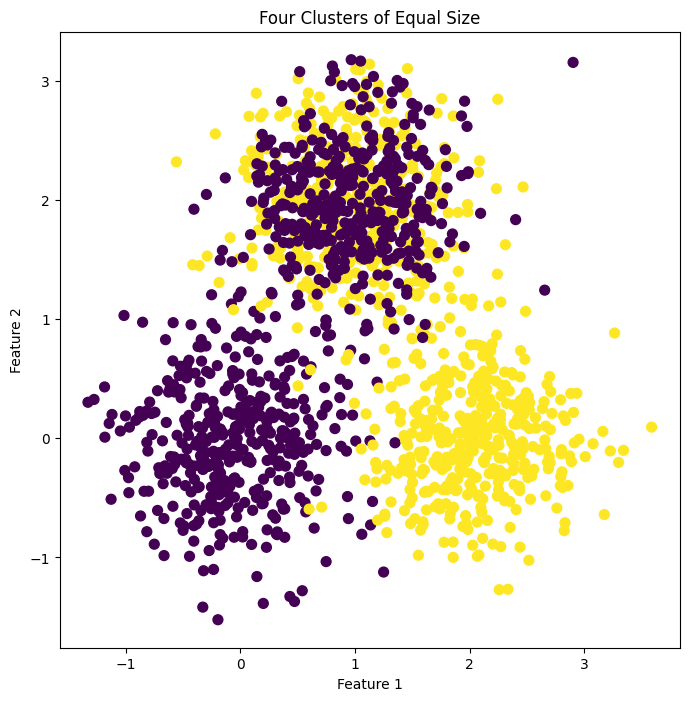

Training data shape: (1000, 2), (1000,)
Test data shape: (600, 2), (600,)


In [8]:
from sklearn.model_selection import KFold

train_data, test_data, val_data = generate_data("data2")


train_data_tensor = data.TensorDataset(torch.tensor(train_data[:, :-1], dtype=torch.float32),
                                        torch.tensor(train_data[:, -1], dtype=torch.float32))
train_loader = data.DataLoader(train_data_tensor, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) #over-write later for k-fold cross-validation
test_data_tensor = data.TensorDataset(torch.tensor(test_data[:, :-1], dtype=torch.float32),
                                       torch.tensor(test_data[:, -1], dtype=torch.float32))
test_loader = data.DataLoader(test_data_tensor, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# initialize fold
kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)


### Regular training

In [9]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# --- Place any constants or unchanging objects outside the loop ---
pl.seed_everything(42, workers=True)
progress_bar = TQDMProgressBar(refresh_rate=10)




# 1. Instantiate the LightningModule
model = LitClassifier(input_features=2, hidden_units=32, learning_rate=LEARNING_RATE)

checkpoint_callback_full_model = ModelCheckpoint(
    monitor='classifier_train_acc',  # Monitor training accuracy
    every_n_epochs=1,                # Save model every epoch
    dirpath='checkpoints/',
    filename='simple-clf-{epoch:02d}',
    save_top_k=1,
    mode='max',
)

train_trainer_1 = pl.Trainer(
    accelerator='gpu',                 # Use GPUs
    devices=1,                         # Number of GPUs to use
    #strategy='ddp_notebook',                    # DistributedDataParallel strategy (best for multi-GPU)
    max_epochs=NUM_EPOCHS,              # Total number of epochs
    callbacks=[checkpoint_callback_full_model, progress_bar],
    logger=pl.loggers.TensorBoardLogger("lightning_logs/", name="simple-clf-train"),
)

test_trainer_1 = pl.Trainer(
    accelerator='gpu',
    devices=1,  # Use only one GPU
    logger = pl.loggers.TensorBoardLogger("lightning_logs/", name="simple-clf-test"),
    # Add the callback here so the Trainer can find the 'best' path
    callbacks=[checkpoint_callback_full_model],
    precision='16-mixed'  # Use mixed precision for testing
)

# --- Phase 1 Training ---
print(f"--- Starting Training for {NUM_EPOCHS} epochs on train_loader ---")
train_trainer_1.fit(model, train_dataloaders=train_loader)

# CRITICAL: Save the path to the best model from this phase
path_after_phase1 = checkpoint_callback_full_model.best_model_path
print(f"Best model from Phase 1 saved to: {path_after_phase1}")

# --- Test 1: Evaluate the model from after Phase 1 ---
print(f"\n--- Testing model from Phase 1 checkpoint: {path_after_phase1} ---")
model.current_test_title = "ROC Curve after training on DataLoader 1"
model = LitClassifier.load_from_checkpoint(path_after_phase1)  # Load the model from Phase 1
model.eval().to('cuda:0')  # Ensure the model is in evaluation mode and on GPU
test_trainer_1.test(model, dataloaders=test_loader, ckpt_path=path_after_phase1)
results_phase1 = model.last_test_results.copy()
results_original_roc = {"fpr": results_phase1["full_roc"]["fpr"], "tpr": results_phase1["full_roc"]["tpr"], "thresholds": results_phase1["full_roc"]["thresholds"], "name": "Original NN data1", "auc": results_phase1["auc"], "model": model}

# Metrics
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
model.eval() # Set to evaluation mode

final_predictions = [] # This will store binary predictions (0s or 1s)
true_labels = []

print("\n--- Manually Calculating Metrics on Test Set ---")
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move input data to the same device as the model
        inputs = inputs.to(device)

        # 1. Get the raw model output (logits) and convert to probabilities
        outputs = torch.sigmoid(model(inputs))

        # 2. Convert probabilities to binary class predictions (0 or 1) using a 0.5 threshold
        preds = (outputs > 0.5).int()

        final_predictions.extend(preds.cpu().numpy().flatten())
        true_labels.extend(labels.cpu().numpy().flatten())

# Ensure they are numpy arrays for sklearn
true_labels = np.array(true_labels)
final_predictions = np.array(final_predictions)

# Now, calculate metrics using the correct binary predictions
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(true_labels, final_predictions)
print(cm)

print("\n--- Classification Report ---")
report = classification_report(true_labels, final_predictions, target_names=['Class 0', 'Class 1'], zero_division=0)
print(report)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--- Starting Training for 1 epochs on train_loader ---



  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 16/16 [00:00<00:00, 60.83it/s, v_num=18]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 16/16 [00:00<00:00, 59.16it/s, v_num=18]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/simple-clf-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/simple-clf-epoch=00-v17.ckpt



Best model from Phase 1 saved to: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/simple-clf-epoch=00-v17.ckpt

--- Testing model from Phase 1 checkpoint: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/simple-clf-epoch=00-v17.ckpt ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 253.61it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5700
AUC: 0.6139
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 108.73it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6873144507408142
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Manually Calculating Metrics on 

### Weighted ROC curve

In [10]:
NUM_CLASSIFIERS = 50
w = np.linspace(0.001, 0.999, NUM_CLASSIFIERS, endpoint=True)
pos_weights = w/(1-w)

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import numpy as np

# --- Place any constants or unchanging objects outside the loop ---
pl.seed_everything(42, workers=True)
progress_bar = TQDMProgressBar(refresh_rate=10)

#store the weighted classifiers of all the folds
list_folds_weighted_clfs = []  # List to store classifiers from all folds
#store the best classfiers of all the folds
list_folds_best_models = []  # List to store best models from all folds

# Dictionary to store the history of each fold
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

# 3. K-fold cross-validation loop
for fold, (train_ids, val_ids) in enumerate(kfold.split(train_data_tensor)):
    list_weighted_clfs = [] # List to store the models trained at each stage
    best_clfs = [] # List to store the best models from each stage
    best_model_paths = [] # List to store the path of the best model from each stage
    print(f"--- Starting Fold {fold + 1}/{K_FOLDS} ---")

    # 4. Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

    train_loader = data.DataLoader(
                      train_data_tensor,
                      batch_size=BATCH_SIZE,
                      sampler=train_subsampler,
                      num_workers=NUM_WORKERS)
    fold_loader = data.DataLoader(
                    train_data_tensor,
                    batch_size=BATCH_SIZE,
                    sampler=val_subsampler,
                    num_workers=NUM_WORKERS)


    for i, pos_weight in enumerate(pos_weights):
        # 1. Instantiate the LightningModule
        model = LitClassifier(input_features=2, hidden_units=32, learning_rate=LEARNING_RATE, pos_weight=pos_weight)
        
        checkpoint_callback = ModelCheckpoint(
            every_n_epochs=1,                # Save model every epoch
            dirpath=f'checkpoints/stage_{i+1}/fold_{fold+1}/',
            filename=f'best-model-fold{fold+1}-{{epoch:02d}}',
            save_top_k=1,
            mode='max',
        )
        
        # 3. Instantiate a NEW Trainer for this specific stage
        trainer = pl.Trainer(
            accelerator='gpu',
            devices=1,
            #strategy='ddp_notebook',
            max_epochs=NUM_EPOCHS, # Number of epochs for THIS stage
            callbacks=[checkpoint_callback, progress_bar],
            logger=pl.loggers.TensorBoardLogger("lightning_logs/", name=f"stage_{i+1}_fold_{fold+1}_ratio_{pos_weight}"),
            precision='16-mixed'
            )
        
        # 4. Train the model. It will start with weights from the previous stage.
        trainer.fit(model, train_dataloaders=train_loader)
        
        # 5. Get the path to the best model from THIS stage and store it
        if checkpoint_callback.best_model_path:
            best_path_this_stage = checkpoint_callback.best_model_path
            print(f"--- Fold {fold+1} Stage {i+1} complete. Best model path: {best_path_this_stage} ---")
            best_model_paths.append(best_path_this_stage)
            
            # 6. CRITICAL: Load the best weights back into the model object
            # This ensures we carry forward the BEST model to the next stage, not the last.
            print(f"Loading best weights from {best_path_this_stage} to continue...")
            model = LitClassifier.load_from_checkpoint(best_path_this_stage, strict=False)  # Use strict=False to ignore missing keys if any
        else:
            print(f"--- Fold {fold+1} Stage {i+1} complete. No checkpoint was saved. ---")
            # If no checkpoint was saved, the model object will just have the weights from the last epoch.

        # 7. Test the model after each stage
        print(f"\n--- Testing model after Fold {fold+1} Stage {i+1} ---")
        trainer.test(model, dataloaders=fold_loader, ckpt_path=best_path_this_stage)
        results_classifier = model.last_test_results.copy()
        current_model = {
            "model": model,
            "fpr": results_classifier["fpr"],
            "tpr": results_classifier["tpr"],
            "threshold": results_classifier["threshold"],
            "full_roc": results_classifier["full_roc"]
        }
        list_weighted_clfs.append(current_model)
        best_clfs = get_best_roc_envelope(list_weighted_clfs, results_original_roc)
    list_folds_weighted_clfs.append(list_weighted_clfs)
    list_folds_best_models.append(best_clfs)




Seed set to 42
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.0

--- Starting Fold 1/4 ---


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.34it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 119.67it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_1/best-model-fold1-epoch=00-v16.ckpt



--- Fold 1 Stage 1 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 1 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 471.42it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.3113
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 364.82it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.26353636384010315
──────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.51it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.83it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_1/best-model-fold1-epoch=00-v16.ckpt



--- Fold 1 Stage 2 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 2 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 476.98it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4283
AUC: 0.1793
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 363.09it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.31480833888053894
──────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 116.00it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 110.45it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_1/best-model-fold1-epoch=00-v16.ckpt



--- Fold 1 Stage 3 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 3 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 413.97it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5817
AUC: 0.7506
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 329.13it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4084720313549042
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.39it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.03it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_1/best-model-fold1-epoch=00-v16.ckpt



--- Fold 1 Stage 4 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 4 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 431.69it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4417
AUC: 0.2055
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 336.05it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3480257987976074
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.46it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.29it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_1/best-model-fold1-epoch=00-v16.ckpt



--- Fold 1 Stage 5 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 5 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 414.52it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5017
AUC: 0.4631
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 325.50it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.28502213954925537
──────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.56it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.92it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_1/best-model-fold1-epoch=00-v16.ckpt



--- Fold 1 Stage 6 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 6 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 413.42it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6183
AUC: 0.6560
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 330.78it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.35826075077056885
──────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.17it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.15it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_1/best-model-fold1-epoch=00-v16.ckpt



--- Fold 1 Stage 7 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 7 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 451.36it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.4110
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 351.48it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.30880895256996155
──────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 157.44it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.06it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_1/best-model-fold1-epoch=00-v16.ckpt



--- Fold 1 Stage 8 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 8 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 465.48it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4300
AUC: 0.3202
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 352.29it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.35373517870903015
──────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.28it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.66it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_1/best-model-fold1-epoch=00-v16.ckpt



--- Fold 1 Stage 9 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 9 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 426.59it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5017
AUC: 0.5008
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 339.50it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3447640538215637
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.48it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.05it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_1/best-model-fold1-epoch=00-v16.ckpt



--- Fold 1 Stage 10 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 10 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 433.32it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.7458
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 344.68it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5482269525527954
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.96it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.89it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_1/best-model-fold1-epoch=00-v16.ckpt



--- Fold 1 Stage 11 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 11 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 461.88it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.6311
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 350.20it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3598458766937256
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.80it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.51it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_1/best-model-fold1-epoch=00-v16.ckpt



--- Fold 1 Stage 12 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 12 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 424.28it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.3285
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 336.06it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.40651023387908936
──────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.77it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.48it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 13 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 13 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 427.15it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.7230
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 337.77it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3905092477798462
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 156.14it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.88it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 14 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 14 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 413.58it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3667
AUC: 0.3866
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 329.01it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4698796570301056
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.21it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.60it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 15 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 15 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 437.39it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5031
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 331.90it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5824799537658691
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.60it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.28it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 16 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 16 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 420.96it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5017
AUC: 0.4807
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 334.06it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4990360140800476
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.42it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.46it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 17 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 17 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 423.69it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6033
AUC: 0.7885
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 336.37it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5120429396629333
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.12it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.56it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 18 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 18 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 527.39it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4350
AUC: 0.3114
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 394.87it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5363060832023621
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.08it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.18it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 19 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 19 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 350.62it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5217
AUC: 0.4335
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 290.26it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.607101559638977
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.72it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.60it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 20 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 20 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 446.23it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4750
AUC: 0.3927
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 347.48it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5619578957557678
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.71it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.80it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 21 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 21 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 546.90it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6117
AUC: 0.7454
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 400.02it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5781631469726562
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.00it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.01it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 22 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 22 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 373.66it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7117
AUC: 0.6207
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 304.96it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5644285082817078
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.03it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.04it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 23 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 23 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 439.58it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6300
AUC: 0.8359
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 341.45it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5809800624847412
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.40it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.17it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 24 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 24 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 404.08it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5183
AUC: 0.5400
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 321.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6516385078430176
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.65it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.73it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 25 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 25 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 377.92it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4100
AUC: 0.4313
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 303.61it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7058771848678589
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.22it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.25it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 26 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 26 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 343.06it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5533
AUC: 0.8329
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 284.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6566348075866699
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.22it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.62it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 27 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 27 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 469.98it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.2847
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 360.82it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8082740306854248
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.60it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 121.20it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 28 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 28 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 366.55it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.6899
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 298.46it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7271549701690674
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.84it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.63it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 29 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 29 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 401.89it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6833
AUC: 0.6158
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 325.76it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7722235321998596
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 159.02it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.68it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 30 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 30 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 434.33it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5533
AUC: 0.6744
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 339.34it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.778638482093811
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.87it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 123.42it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 31 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 31 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 377.62it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6017
AUC: 0.6421
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 286.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8610087037086487
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.93it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.96it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 32 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 32 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 411.91it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6283
AUC: 0.6648
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 311.37it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.884780764579773
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.28it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.54it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 33 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 33 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 405.17it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5100
AUC: 0.5141
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 329.36it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            1.142561912536621
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.05it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.63it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 34 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 34 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 402.14it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.5840
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 326.11it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.0754063129425049
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 118.86it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 111.48it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 35 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 35 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 389.44it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6383
AUC: 0.6507
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 315.50it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.1438422203063965
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.43it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.89it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 36 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 36 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 423.72it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.4179
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 334.70it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.5850701332092285
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.16it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.57it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 37 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 37 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 440.55it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6817
AUC: 0.8011
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 339.80it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.2598055601119995
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.70it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.04it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 38 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 38 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 419.48it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3800
AUC: 0.3139
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 322.85it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.3733744621276855
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.82it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.12it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 39 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 39 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 397.43it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5050
AUC: 0.4280
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 310.80it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.3911501169204712
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 154.27it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.10it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 40 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 40 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 416.54it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6283
AUC: 0.5547
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 335.09it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.5437144041061401
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 155.19it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.92it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 41 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 41 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 390.54it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3967
AUC: 0.3652
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 314.37it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            2.01842999458313
────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 159.13it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.52it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 42 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 42 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 399.51it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5933
AUC: 0.6165
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 293.32it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           2.0989768505096436
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.70it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.50it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 43 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 43 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 376.88it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5700
AUC: 0.5441
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 292.18it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           2.0534048080444336
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.85it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.61it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 44 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 44 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 397.51it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.7408
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 322.18it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            3.139504909515381
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.13it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.67it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 45 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 45 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 406.59it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5917
AUC: 0.5881
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 326.44it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            3.023639678955078
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.70it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.97it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 46 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 46 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 413.92it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.7304
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 331.66it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           3.3313162326812744
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.96it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.04it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 47 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 47 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 448.41it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5217
AUC: 0.6012
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 351.21it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           5.4116926193237305
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 162.61it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.17it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 48 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 48 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 359.08it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5300
AUC: 0.6040
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 294.05it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            7.803292751312256
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 166.03it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.56it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 49 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 49 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 355.82it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.7215
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 295.61it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           13.104984283447266
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 161.20it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.31it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 50 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 50 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 482.51it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4667
AUC: 0.3895
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 375.06it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           447.21600341796875
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

--- Starting Fold 2/4 ---
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.71it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.14it/s, v_num=1]


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_2/best-model-fold2-epoch=00-v15.ckpt


--- Fold 2 Stage 1 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 1 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 428.47it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6717
AUC: 0.6926
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 344.40it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.35171830654144287
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.73it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.00it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 2 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 2 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 402.34it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4017
AUC: 0.4246
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 325.97it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.29439276456832886
──────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.33it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.80it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 3 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 3 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 388.08it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3733
AUC: 0.3372
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 313.62it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.28272899985313416
──────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 155.52it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.29it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 4 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 4 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 503.49it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.1836
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 376.21it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.29246053099632263
──────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 158.35it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.62it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 5 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 5 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 389.71it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.3508
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 309.56it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.27213746309280396
──────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.83it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.69it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 6 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 6 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 402.22it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.3203
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 315.52it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3445972502231598
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.60it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.68it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 7 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 7 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 356.59it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4017
AUC: 0.2891
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 296.11it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3693988621234894
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.76it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.85it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 8 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 8 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 442.16it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.2929
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 335.07it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.32052934169769287
──────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.63it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.92it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 9 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 9 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 548.71it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.2372
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 409.70it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.35175973176956177
──────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.72it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.12it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 10 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 10 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 399.58it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4317
AUC: 0.2894
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 324.68it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.39458993077278137
──────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.02it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.51it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 11 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 11 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 299.34it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4983
AUC: 0.5714
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 250.48it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5361388325691223
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.69it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.65it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 12 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 12 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 520.21it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3967
AUC: 0.3734
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 400.17it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4720862805843353
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.10it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.97it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 13 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 13 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 433.83it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4800
AUC: 0.4056
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 346.20it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4157777428627014
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.09it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.95it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 14 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 14 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 408.89it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4767
AUC: 0.3828
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 309.19it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4747370779514313
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.59it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.95it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 15 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 15 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 394.90it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4367
AUC: 0.4165
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 322.11it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.46131592988967896
──────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.10it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.70it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 16 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 16 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 433.61it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6917
AUC: 0.7707
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 332.10it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4780513644218445
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.62it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.98it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 17 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 17 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 476.47it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5167
AUC: 0.6713
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 364.02it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5255148410797119
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.79it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.59it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 18 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 18 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 440.22it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6017
AUC: 0.7070
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 340.29it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5748050808906555
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.52it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.19it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 19 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 19 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 486.79it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5683
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 359.51it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.564857542514801
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.38it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.08it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 20 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 20 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 378.27it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.2656
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 309.18it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.563645601272583
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.17it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.60it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 21 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 21 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 382.38it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6767
AUC: 0.7937
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 314.43it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5607650876045227
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 154.31it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.15it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 22 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 22 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 399.85it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.2348
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 323.73it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6469289064407349
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.15it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.43it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 23 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 23 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 395.96it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7117
AUC: 0.7719
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 321.42it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6000611186027527
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.56it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.30it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 24 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 24 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 385.58it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5967
AUC: 0.5590
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 314.42it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6555531024932861
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.83it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.52it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 25 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 25 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 394.02it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5233
AUC: 0.5371
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 317.38it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6885141134262085
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.52it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.30it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 26 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 26 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 431.50it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4917
AUC: 0.4631
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 344.60it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7473665475845337
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 155.07it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.64it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 27 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 27 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 478.77it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6900
AUC: 0.6760
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 353.72it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6783037185668945
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.68it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.32it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 28 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 28 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 444.87it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5517
AUC: 0.6527
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 346.11it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7374554872512817
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.76it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.82it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 29 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 29 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 432.72it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6667
AUC: 0.6373
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 344.20it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7640712261199951
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.75it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.29it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 30 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 30 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 396.45it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4883
AUC: 0.1754
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 317.76it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.9516602754592896
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 156.54it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.39it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 31 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 31 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 387.10it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4900
AUC: 0.4873
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 316.12it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.913270890712738
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.36it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.68it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 32 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 32 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 414.96it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5017
AUC: 0.7890
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 334.31it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8461651802062988
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.78it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.91it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 33 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 33 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 389.41it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6200
AUC: 0.6144
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 314.51it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8948971629142761
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.03it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.37it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 34 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 34 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 373.87it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5233
AUC: 0.7575
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 292.79it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.0804647207260132
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.07it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.97it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 35 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 35 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 390.23it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6267
AUC: 0.6038
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 316.36it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            1.050389051437378
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.96it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.53it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 36 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 36 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 447.68it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5433
AUC: 0.5693
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 336.37it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.0784318447113037
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.48it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.49it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 37 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 37 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 399.31it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.6960
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 322.79it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            1.060796856880188
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.74it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.92it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 38 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 38 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 435.22it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5133
AUC: 0.7785
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 329.19it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.2160016298294067
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.01it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.36it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 39 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 39 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 391.13it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5133
AUC: 0.6796
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 318.61it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.2896370887756348
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 154.67it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.28it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 40 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 40 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 410.70it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3417
AUC: 0.3916
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 317.01it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            1.603961706161499
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 115.40it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 109.89it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 41 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 41 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 411.60it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4450
AUC: 0.3608
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 333.62it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            2.030611991882324
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.74it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.78it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 42 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 42 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 416.75it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5133
AUC: 0.5357
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 335.97it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.6128144264221191
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.69it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.23it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 43 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 43 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 444.58it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4983
AUC: 0.3036
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 351.34it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           2.9028141498565674
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 155.47it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.29it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 44 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 44 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 449.57it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5167
AUC: 0.6617
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 350.22it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            2.22929310798645
────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 156.83it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.64it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 45 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 45 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 419.47it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4983
AUC: 0.5487
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 328.79it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           2.9618287086486816
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.68it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 122.27it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 46 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 46 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 442.82it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4417
AUC: 0.2823
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 337.14it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            4.563401699066162
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 155.58it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.66it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 47 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 47 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 414.14it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6183
AUC: 0.8151
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 316.52it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            3.989292860031128
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.47it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.87it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 48 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 48 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 389.06it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.7576
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 316.96it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            5.778364181518555
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.07it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.62it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 49 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 49 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 378.91it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4933
AUC: 0.4571
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 310.38it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           12.038694381713867
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.39it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.57it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_2/best-model-fold2-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_2/best-model-fold2-epoch=00-v15.ckpt



--- Fold 2 Stage 50 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_2/best-model-fold2-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_2/best-model-fold2-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 2 Stage 50 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 291.66it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4917
AUC: 0.5887
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 244.53it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            392.4534912109375
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

--- Starting Fold 3/4 ---
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.07it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.81it/s, v_num=1]


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_3/best-model-fold3-epoch=00-v15.ckpt


--- Fold 3 Stage 1 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 1 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 390.75it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.4016
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 319.20it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.21381619572639465
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.83it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.61it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 2 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 2 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 403.55it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4733
AUC: 0.4541
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 320.96it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.2677272856235504
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.43it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 125.85it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 3 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 3 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 385.94it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6800
AUC: 0.6370
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 291.28it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.42000195384025574
──────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 119.72it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 113.48it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 4 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 4 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 280.98it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4983
AUC: 0.1562
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 222.14it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.2946195602416992
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 116.11it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 104.33it/s, v_num=1]
--- Fold 3 Stage 5 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Testing model after Fold 3 Stage 5 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 381.20it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.2747
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 309.61it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.35650813579559326
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.58it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.21it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 6 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 6 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 461.43it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6117
AUC: 0.6967
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 343.66it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4193503260612488
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.94it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 125.68it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 7 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 7 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 393.42it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6983
AUC: 0.6073
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 311.88it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.41862401366233826
──────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.96it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.73it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 8 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 8 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 392.66it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4967
AUC: 0.2948
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 314.85it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.32524794340133667
──────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.89it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.06it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 9 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 9 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 456.58it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.6605
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 340.10it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.32704225182533264
──────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 123.99it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 115.07it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 10 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 10 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 377.17it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.2789
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 303.70it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.39484545588493347
──────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 123.95it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 115.90it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 11 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 11 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 432.87it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6217
AUC: 0.7795
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 331.05it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.37388384342193604
──────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.16it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.50it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 12 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 12 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 323.37it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6717
AUC: 0.6044
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 266.59it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss             0.3908711373806
────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.02it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.12it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 13 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 13 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 432.31it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.3574
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 329.58it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.41795462369918823
──────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.98it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.20it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 14 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 14 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 443.69it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5100
AUC: 0.6245
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 350.96it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.458295077085495
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.46it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.90it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 15 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 15 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 437.85it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4950
AUC: 0.1974
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 337.67it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4747448265552521
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.18it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.45it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 16 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 16 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 366.90it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5200
AUC: 0.6699
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 299.35it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.49654531478881836
──────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.15it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.23it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 17 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 17 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 372.70it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7133
AUC: 0.7588
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 295.28it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.47539180517196655
──────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.84it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.85it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 18 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 18 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 430.02it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7267
AUC: 0.6373
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 328.56it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.47468113899230957
──────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.73it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.34it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 19 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 19 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 420.57it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.6181
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 326.79it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5222291946411133
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.07it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 123.03it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 20 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 20 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 398.49it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5367
AUC: 0.8385
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 319.00it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5139432549476624
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.88it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.10it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 21 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 21 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 385.28it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6667
AUC: 0.7366
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 315.62it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5356821417808533
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.53it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.52it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 22 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 22 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 376.84it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4683
AUC: 0.4070
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 287.62it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6296510100364685
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.96it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.65it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 23 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 23 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 420.23it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4500
AUC: 0.4279
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 319.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6341978311538696
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 114.13it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 108.59it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 24 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 24 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 408.13it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7267
AUC: 0.7935
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 311.52it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6008151173591614
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.36it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.44it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 25 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 25 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 513.08it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.6749
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 395.00it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6787229180335999
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.69it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.51it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 26 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 26 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 276.23it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6567
AUC: 0.6741
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 216.49it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6765835285186768
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 96.70it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 89.91it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 27 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 27 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 407.12it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.7788
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 321.21it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7313083410263062
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.51it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.15it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 28 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 28 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 416.20it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6167
AUC: 0.7929
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 325.68it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7066786885261536
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.53it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.29it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 29 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 29 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 441.84it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6717
AUC: 0.6687
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 352.47it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7651434540748596
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 154.94it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.46it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 30 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 30 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 475.27it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4817
AUC: 0.4994
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 364.77it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8528501391410828
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.29it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.76it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 31 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 31 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 499.96it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4233
AUC: 0.4202
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 377.89it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.9972931146621704
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.82it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.00it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 32 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 32 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 451.13it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4700
AUC: 0.4828
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 352.91it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.9435225129127502
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 154.06it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.01it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 33 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 33 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 412.11it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4850
AUC: 0.2311
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 331.33it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            1.104198932647705
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.93it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.23it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 34 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 34 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 243.14it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5033
AUC: 0.6634
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 204.53it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.9816341400146484
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 154.31it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.96it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 35 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 35 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 470.93it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4950
AUC: 0.5172
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 354.17it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.1124221086502075
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.28it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.78it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 36 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 36 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 506.20it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6117
AUC: 0.7919
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 373.45it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.1248645782470703
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.39it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.99it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 37 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 37 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 504.95it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5083
AUC: 0.7825
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 386.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.0040040016174316
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.80it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.95it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 38 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 38 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 466.37it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4933
AUC: 0.4516
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 352.04it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.2658902406692505
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.34it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.42it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 39 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 39 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 458.05it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3783
AUC: 0.2773
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 349.60it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.5569061040878296
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.49it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.95it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 40 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 40 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 258.52it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.8139
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 212.06it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            1.384100079536438
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.16it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.26it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 41 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 41 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 397.63it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6350
AUC: 0.5870
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 316.43it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            1.674343228340149
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 156.77it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.77it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 42 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 42 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 416.60it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3083
AUC: 0.3809
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 327.02it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            1.920440673828125
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.99it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.94it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 43 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 43 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 393.59it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5291
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 305.37it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.6541298627853394
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.16it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.09it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 44 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 44 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 376.65it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5017
AUC: 0.8379
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 295.63it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.8238729238510132
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.70it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.46it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 45 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 45 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 419.10it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4783
AUC: 0.4064
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 324.26it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           3.5224475860595703
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.44it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.18it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 46 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 46 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 407.61it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4067
AUC: 0.2260
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 312.28it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            5.313297748565674
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.22it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.39it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 47 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 47 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 389.89it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.6414
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 313.81it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            3.734692335128784
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.32it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.09it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 48 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 48 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 456.94it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4983
AUC: 0.5241
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 347.81it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            9.065688133239746
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.25it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.29it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 49 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 49 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 278.16it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6433
AUC: 0.6966
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 210.70it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           17.360986709594727
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 154.98it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.32it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_3/best-model-fold3-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_3/best-model-fold3-epoch=00-v15.ckpt



--- Fold 3 Stage 50 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_3/best-model-fold3-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_3/best-model-fold3-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 3 Stage 50 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 418.53it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4117
AUC: 0.4208
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 314.10it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            262.9235534667969
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

--- Starting Fold 4/4 ---
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.43it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.41it/s, v_num=1]


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_4/best-model-fold4-epoch=00-v14.ckpt


--- Fold 4 Stage 1 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 1 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 388.03it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6300
AUC: 0.8496
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 313.01it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.35541248321533203
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.41it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.25it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 2 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 2 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 392.34it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.2767
AUC: 0.1887
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 307.33it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3728678524494171
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.30it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.11it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 3 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 3 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 410.83it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3933
AUC: 0.2846
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 316.83it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3034558594226837
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.51it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.92it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 4 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 4 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 401.83it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.2477
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 317.32it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.29967671632766724
──────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.82it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.57it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 5 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 5 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 396.00it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7300
AUC: 0.8100
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 311.56it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.352988600730896
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 116.28it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 109.67it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 6 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 6 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 400.21it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6083
AUC: 0.5854
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 319.10it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3511785566806793
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.43it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.55it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 7 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 7 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 516.88it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.4303
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 389.95it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.32768118381500244
──────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.69it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.79it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 8 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 8 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 393.92it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4233
AUC: 0.4235
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 316.59it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4550479054450989
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.31it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.69it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 9 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 9 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 399.95it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7317
AUC: 0.8429
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 321.73it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3798511028289795
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.02it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.22it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 10 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 10 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 408.71it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4433
AUC: 0.4454
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 324.94it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4161930978298187
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.27it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.95it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 11 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 11 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 493.92it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4500
AUC: 0.4112
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 384.91it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.43674129247665405
──────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.80it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.89it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 12 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 12 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 424.35it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.2088
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 323.39it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.409930020570755
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.95it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.63it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 13 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 13 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 380.18it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5967
AUC: 0.6291
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 297.84it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4439248740673065
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.00it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.11it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 14 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 14 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 416.31it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.2235
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 314.58it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4529549181461334
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.96it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.45it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 15 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 15 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 382.99it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4983
AUC: 0.3931
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 308.88it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.46103712916374207
──────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.68it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.72it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 16 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 16 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 381.11it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.2795
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 310.16it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.501644492149353
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 114.98it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 108.25it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 17 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 17 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 414.67it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.6125
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 321.01it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.49009886384010315
──────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.68it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.15it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 18 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 18 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 385.72it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4333
AUC: 0.4211
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 309.69it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5325526595115662
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.21it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.34it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 19 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 19 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 298.37it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4833
AUC: 0.3995
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 235.63it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5521606802940369
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.42it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.28it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 20 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 20 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 408.15it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4950
AUC: 0.5282
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 316.69it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6115013360977173
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.95it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.18it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 21 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 21 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 378.00it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6533
AUC: 0.6113
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 305.01it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6004190444946289
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.58it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.21it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 22 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 22 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 384.64it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6733
AUC: 0.6953
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 310.28it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5954717397689819
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.48it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.95it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 23 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 23 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 403.10it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6967
AUC: 0.7481
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 322.02it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5849170684814453
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.30it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.46it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 24 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 24 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 364.67it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.3744
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 297.38it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7001966238021851
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.53it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.49it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 25 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 25 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 416.56it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5500
AUC: 0.8193
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 325.55it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6579862236976624
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.90it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.24it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 26 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 26 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 428.73it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3667
AUC: 0.4089
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 330.10it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.748766303062439
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.94it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.79it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 27 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 27 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 365.61it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.2225
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 293.60it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.9041798114776611
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.08it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.93it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 28 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 28 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 441.82it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6100
AUC: 0.6868
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 339.69it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7356960773468018
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 122.16it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 113.45it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 29 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 29 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 478.65it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6683
AUC: 0.7018
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 356.40it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7992081046104431
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.52it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.15it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 30 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 30 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 357.62it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4983
AUC: 0.5332
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 269.84it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8268755078315735
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.14it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 122.84it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 31 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 31 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 348.77it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6517
AUC: 0.6040
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 270.46it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8394176959991455
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.98it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.77it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 32 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 32 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 326.95it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5396
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 270.19it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.0062744617462158
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.37it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.63it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 33 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 33 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 320.95it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5017
AUC: 0.6993
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 254.10it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.9018452167510986
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.28it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 121.92it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 34 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 34 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 321.15it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6667
AUC: 0.7455
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 254.20it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.0161296129226685
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.30it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.72it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 35 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 35 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 405.98it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.8181
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 326.45it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.9446213841438293
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.26it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.68it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 36 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 36 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 386.91it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4967
AUC: 0.3704
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 297.02it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.4169176816940308
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.69it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 123.44it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 37 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 37 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 380.82it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5217
AUC: 0.6054
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 292.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.2709624767303467
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.22it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 122.50it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 38 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 38 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 407.45it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4883
AUC: 0.4136
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 327.60it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.6010371446609497
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.59it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.82it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 39 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 39 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 433.26it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3767
AUC: 0.2001
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 335.05it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.7111637592315674
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 115.92it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 109.92it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 40 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 40 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 392.22it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6783
AUC: 0.6781
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 304.63it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.6800243854522705
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.26it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.67it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 41 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 41 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 396.97it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3617
AUC: 0.3970
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 315.18it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss             2.0590980052948
────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.59it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.99it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 42 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 42 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 264.87it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5683
AUC: 0.7506
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 217.18it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.8871266841888428
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.12it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.30it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 43 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 43 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 407.46it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4983
AUC: 0.5937
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 323.88it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           2.0430335998535156
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 154.25it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.29it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 44 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 44 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 416.95it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5767
AUC: 0.6691
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 334.77it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.8497685194015503
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.45it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.79it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 45 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 45 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 481.98it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5700
AUC: 0.5261
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 375.04it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            3.184138536453247
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.44it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.83it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 46 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 46 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 394.66it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6167
AUC: 0.6521
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 319.11it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            3.918490409851074
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.45it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.82it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 47 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 47 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 420.43it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6633
AUC: 0.7142
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 324.33it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            5.225701808929443
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 111.16it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 105.96it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 48 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 48 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 403.77it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5083
AUC: 0.6146
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 321.47it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            8.878403663635254
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 157.26it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.99it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 49 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 49 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 551.31it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5917
AUC: 0.6686
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 419.04it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           11.299616813659668
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.39it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.42it/s, v_num=1]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_4/best-model-fold4-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_4/best-model-fold4-epoch=00-v14.ckpt



--- Fold 4 Stage 50 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_4/best-model-fold4-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_4/best-model-fold4-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 4 Stage 50 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 421.86it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5024
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 337.22it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            219.2882537841797
───────────────────────────────────────────────────────────

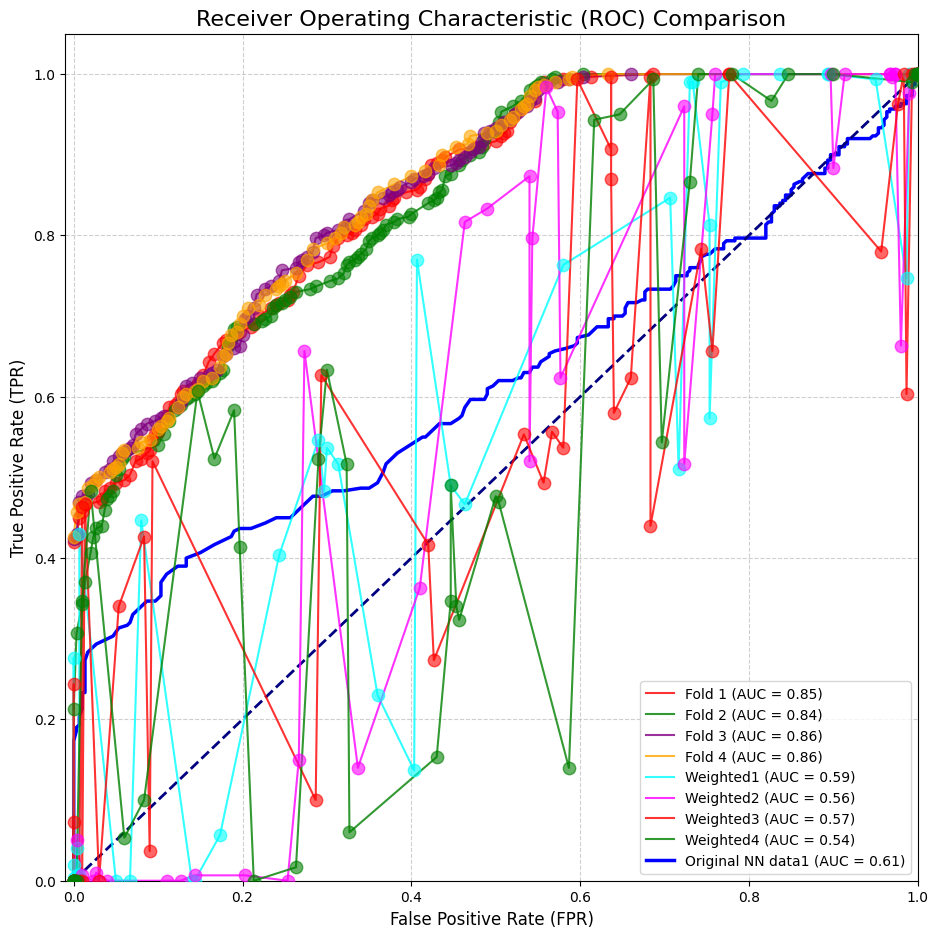

In [12]:
# plot the best classifiers of all folds
results_lists = []
results_lists.extend(list_folds_best_models)
results_lists.extend(list_folds_weighted_clfs)
plot_roc_comparison(
    results_lists=results_lists,
    names=["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Weighted1", "Weighted2", "Weighted3", "Weighted4"],
    results_original_roc=results_original_roc
)

### Ensemble prediction using voting

In [13]:


# --- Loop through all the FPR values to generate the ensemble ROC curve ---

ensemble_results_soft = []
ensemble_results_hard = []

print("\n--- Generating Ensemble ROC Curve by iterating through FPR values ---")
# We iterate from a low to high target_fpr to trace the curve
for target_fpr in np.linspace(0.0, 1.0, 50): 
    # 1. Assign the function's output to a single variable first.
    result_tuple = predict_ensemble_and_evaluate(
        list_folds_best_models=list_folds_best_models,
        test_loader=test_loader,
        target_fpr=target_fpr
    )
    
    if result_tuple is not None:
        
        for voting_method, metrics in result_tuple.items():
            # Create a dictionary for each point and append it to the list
            if voting_method == 'soft_voting':
                point_dict = {'fpr': metrics['fpr'], 'tpr': metrics['tpr']}
                ensemble_results_soft.append(point_dict)
            else:
                point_dict = {'fpr': metrics['fpr'], 'tpr': metrics['tpr']}
                ensemble_results_hard.append(point_dict)
            
        
# Ensure the curve starts at (0, 0)
    if not ensemble_results_soft or ensemble_results_soft[0]['fpr'] > 0.0:
        ensemble_results_soft.insert(0, {
            'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf
        })

    # Ensure the curve ends at (1, 1)
    if ensemble_results_soft[-1]['fpr'] < 1.0 or ensemble_results_soft[-1]['tpr'] < 1.0:
        ensemble_results_soft.append({
            'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0
        })

    if not ensemble_results_hard or ensemble_results_hard[0]['fpr'] > 0.0:
        ensemble_results_hard.insert(0, {
            'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf
        })

    # Ensure the curve ends at (1, 1)
    if ensemble_results_hard[-1]['fpr'] < 1.0 or ensemble_results_hard[-1]['tpr'] < 1.0:
        ensemble_results_hard.append({
            'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0
        })







--- Generating Ensemble ROC Curve by iterating through FPR values ---
Extracting full dataset from DataLoader for scikit-learn compatibility...
-> Extracted 600 samples.


--- Ensemble Results ---
Target FPR: 0.0000
Soft Voting -> Achieved [TPR: 0.0000, FPR: 0.0000]
Hard Voting -> Resulted in [TPR: 0.4167, FPR: 0.0000]
Extracting full dataset from DataLoader for scikit-learn compatibility...
-> Extracted 600 samples.


--- Ensemble Results ---
Target FPR: 0.0204
Soft Voting -> Achieved [TPR: 0.4900, FPR: 0.0233]
Hard Voting -> Resulted in [TPR: 0.4700, FPR: 0.0100]
Extracting full dataset from DataLoader for scikit-learn compatibility...
-> Extracted 600 samples.


--- Ensemble Results ---
Target FPR: 0.0408
Soft Voting -> Achieved [TPR: 0.5000, FPR: 0.0400]
Hard Voting -> Resulted in [TPR: 0.4933, FPR: 0.0233]
Extracting full dataset from DataLoader for scikit-learn compatibility...
-> Extracted 600 samples.


--- Ensemble Results ---
Target FPR: 0.0612
Soft Voting -> Achieved [TPR: 


--- Plotting all ROC curves for comparison ---


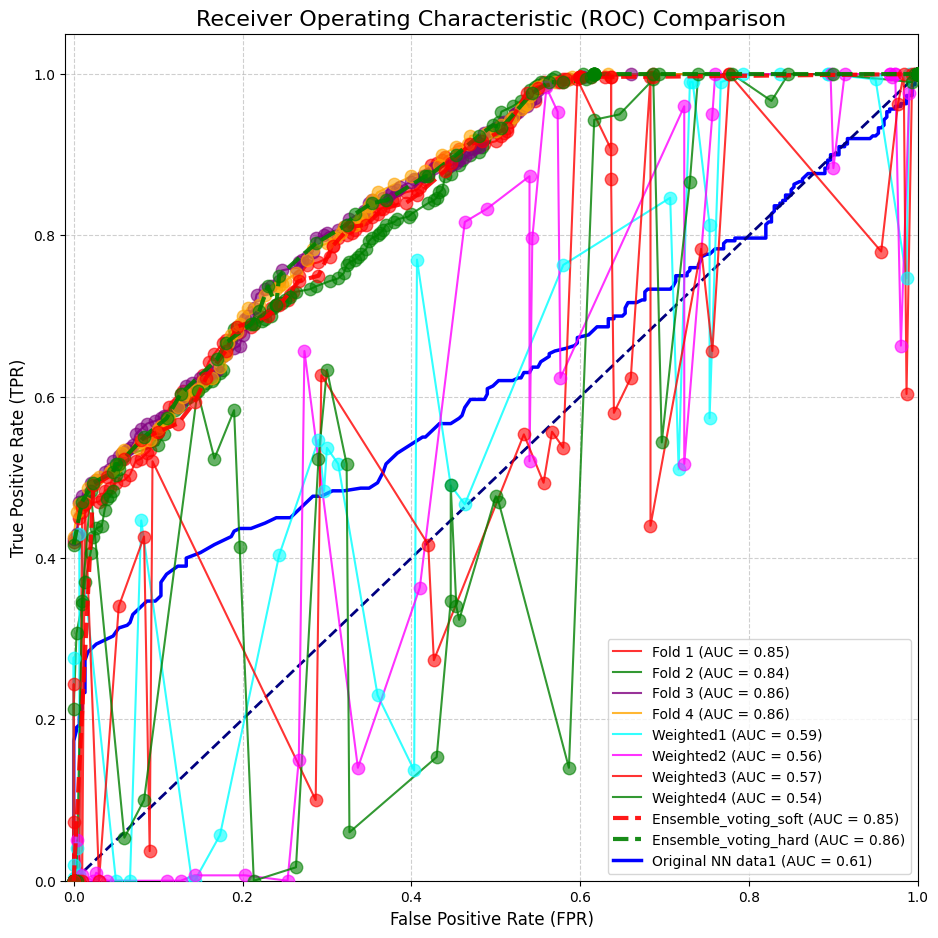

In [14]:
# plot the best classifiers of all folds
results_lists = []
results_lists.extend(list_folds_best_models)
results_lists.extend(list_folds_weighted_clfs)
results_lists.append(ensemble_results_soft)
results_lists.append(ensemble_results_hard)


# --- Plot the final comparison ---
print("\n--- Plotting all ROC curves for comparison ---")
plot_roc_comparison(
    results_lists=results_lists,
    names=["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Weighted1", "Weighted2", "Weighted3", "Weighted4", "Ensemble_voting_soft", "Ensemble_voting_hard"],
    results_original_roc=results_original_roc
)

## Check performances

## Check performance on test1 and test2

In [15]:
def roc_performance_tester(classifier_list, test_loader):

    list_weighted_clfs = []  # Reset the list for final testing
    for i, model_info in enumerate(classifier_list):
        trainer = pl.Trainer(
            accelerator='gpu',
            devices=1,
            #strategy='ddp_notebook',
            max_epochs=NUM_EPOCHS, # Number of epochs for THIS stage
            callbacks=[checkpoint_callback, progress_bar],
            logger=pl.loggers.TensorBoardLogger("lightning_logs/", name=f"stage_{i+1}"),
            precision='16-mixed'
            )

        model = model_info["model"]
        raw_threshold = model_info["threshold"]


        # CORRECTED: Use isinstance() to check if model is a string
        if isinstance(model, str):
            print(f"Skipping model {i+1} as it is a string placeholder: '{model}'")
            continue

        # Check if the stored threshold is a NumPy number or a PyTorch Tensor
        if isinstance(raw_threshold, (np.number, torch.Tensor)):
            # If it is, we can safely call .item() to extract the Python float
            threshold = raw_threshold.item()
        else:
            # Otherwise, it's already a float or something that can be cast to one
            threshold = float(raw_threshold)
        model.current_test_threshold = threshold  # Set the threshold for this model

        # This code will now only run if 'model' is a PyTorch Lightning module
        # and not a string.
        print(f"--- Testing model {i+1} ---")

        trainer.test(model, dataloaders=test_loader, ckpt_path=None)
        
        results_classifier = model.last_test_results.copy()
        current_model = {
            "model": model,
            "fpr": results_classifier["fpr"],
            "tpr": results_classifier["tpr"],
            "threshold": results_classifier["threshold"],
            "full_roc": results_classifier["full_roc"]
        }
        list_weighted_clfs.append(current_model)

    # Ensure the curve starts at (0, 0)
    if not list_weighted_clfs or list_weighted_clfs[0]['fpr'] > 0.0:
        list_weighted_clfs.insert(0, {
            'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf
        })

    # Ensure the curve ends at (1, 1)
    if list_weighted_clfs[-1]['fpr'] < 1.0 or list_weighted_clfs[-1]['tpr'] < 1.0:
        list_weighted_clfs.append({
            'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0
        })

    return list_weighted_clfs